Genera il training set campionando delle sinusoidi


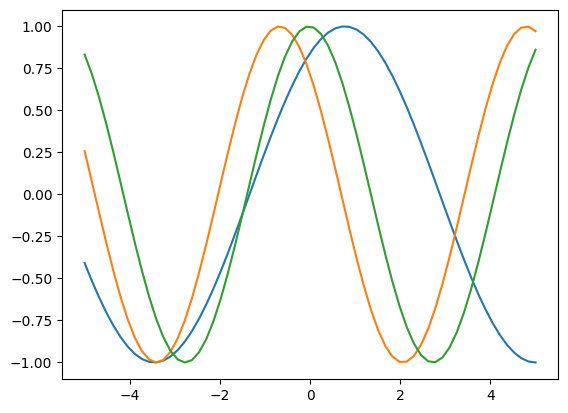

Crea il discriminatore
Addestra il discriminatore
-------+-------------
 epoca | accuratezza 
-------+-------------
    0  |   0.5078125
    1  |   0.671875
    2  |   0.546875
    3  |   0.59375
    4  |   0.6328125
    5  |   0.6484375
    6  |   0.6875
    7  |   0.7109375
    8  |   0.7109375
    9  |   0.6953125
   10  |   0.7734375
   11  |   0.8046875
   12  |   0.7890625
   13  |   0.8359375
   14  |   0.8359375
   15  |   0.828125
   16  |   0.8203125
   17  |   0.8671875
   18  |   0.875
   19  |   0.8984375
   20  |   0.8515625
   21  |   0.8984375
   22  |   0.890625
   23  |   0.9453125
   24  |   0.9140625
   25  |   0.953125
   26  |   0.890625
   27  |   0.953125
   28  |   0.8984375
   29  |   0.9609375
   30  |   0.9375
   31  |   0.8984375


In [2]:
"""
    Generatore di curve sinusoidali

    (una curva è descritta da un insieme di punti (x,y) del piano)
"""
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, LeakyReLU

import numpy as np
from numpy.random import randint, uniform

import matplotlib.pyplot as plt

TRAIN_LEN = 64
TRAIN_SIZE = 8192
BATCH = 128
X_MIN, X_MAX = -5.0, 5.0
Y_MIN, Y_MAX = -1.0, 1.0

X_COORDS = np.linspace(X_MIN , X_MAX, TRAIN_LEN)

print("Genera il training set campionando delle sinusoidi")

X_TRAIN = np.zeros((TRAIN_SIZE, TRAIN_LEN))
for i in range(0, TRAIN_SIZE):
    scale = uniform(0.5, 2.0)
    phase = uniform(np.math.pi)
    X_TRAIN[i] = np.array([np.sin(scale*x + phase) for x in X_COORDS])
    
plt.plot(X_COORDS, X_TRAIN[0])
plt.plot(X_COORDS, X_TRAIN[1])
plt.plot(X_COORDS, X_TRAIN[2])
plt.show()

print("Crea il discriminatore")

DIS_DROPOUT = 0.4
discriminator = Sequential()
discriminator.add(Dense((TRAIN_LEN), activation = "relu"))
discriminator.add(Dropout(DIS_DROPOUT))
discriminator.add(Dense(TRAIN_LEN * 2, activation = "relu"))
discriminator.add(Dropout(DIS_DROPOUT))
discriminator.add(Dense(1, activation = "sigmoid"))
discriminator.compile(optimizer = "adam",
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])

print("Addestra il discriminatore")

BATCH_SIZE = 128
EPOCHS = 32

ONES = np.ones((BATCH_SIZE//2))   # vettore di label 1
ZEROS = np.zeros((BATCH_SIZE//2)) # vettore di label 0
ONEZEROS = (ONES, ZEROS)
NOISE = uniform(Y_MIN, Y_MAX, size = (TRAIN_SIZE, TRAIN_LEN))

print("-------+-------------")
print(" epoca | accuratezza ")
print("-------+-------------")

for i in range(EPOCHS):
  # Sceglie BATCH_SIZE//2 indici e li torna in n
  n = randint(0, TRAIN_SIZE, size = BATCH_SIZE//2)
  # Ora prepara un batch di training record, metà
  # training (label 1) metà a caso (label 0)
  x = np.concatenate((X_TRAIN[n], NOISE[n]))
  y = np.concatenate(ONEZEROS)
  dummy, acc = discriminator.train_on_batch(x, y)
  print(f"  {i:3}  |   {acc}")


Crea il generatore
Crea la GAN
Addestra la GAN
-------+------------------------+------------------------
 epoca | accuratezza discrimin. | accuratezza generatore 
-------+------------------------+------------------------
  000  |        0.91406         |       0.00000
  001  |        0.90625         |       0.01562
  002  |        0.92188         |       0.01562
  003  |        1.00000         |       0.00000
  004  |        0.97656         |       0.00000
  005  |        0.99219         |       0.00000
  006  |        0.97656         |       0.00000
  007  |        0.98438         |       0.00000
  008  |        0.99219         |       0.00000
  009  |        0.99219         |       0.00000
  010  |        0.99219         |       0.00000
  011  |        0.99219         |       0.00000
  012  |        0.99219         |       0.00000
  013  |        1.00000         |       0.00000
  014  |        0.98438         |       0.00000
  015  |        0.97656         |       0.00000
  016  |   

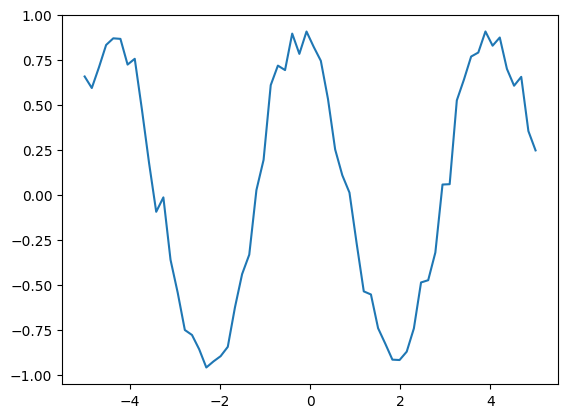

In [3]:
print("Crea il generatore")

generator = Sequential()
generator.add(Dense(TRAIN_LEN, activation = "relu"))
generator.add(Dense(256, activation = "relu"))
generator.add(Dense(TRAIN_LEN, activation = "tanh"))
generator.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])

print("Crea la GAN")

gan = Sequential()
gan.add(generator)
discriminator.trainable = False
gan.add(discriminator)
gan.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

print("Addestra la GAN")

EPOCHS = 64

print("-------+------------------------+------------------------")
print(" epoca | accuratezza discrimin. | accuratezza generatore ")
print("-------+------------------------+------------------------")

for e in range(EPOCHS):
    for k in range(TRAIN_SIZE//BATCH):
        n = randint(0, TRAIN_SIZE, size = BATCH//2)

        x = np.concatenate((X_TRAIN[n], generator.predict(NOISE[n], verbose=False)))
        y = np.concatenate(ONEZEROS)
        discriminator.trainable = True
        d_loss, d_acc = discriminator.train_on_batch(x, y)
        discriminator.trainable = False

        g_loss, g_acc = gan.train_on_batch(NOISE[n], ONES)
    
    print(f"  {e:03n}  |        {d_acc:.5f}         |       {g_acc:.5f}")

x = uniform(Y_MIN, Y_MAX, size = (1, TRAIN_LEN))
y = generator.predict(x)[0]

plt.plot(X_COORDS, y)
plt.show()

1/1 [==============================] - 0s 16ms/step


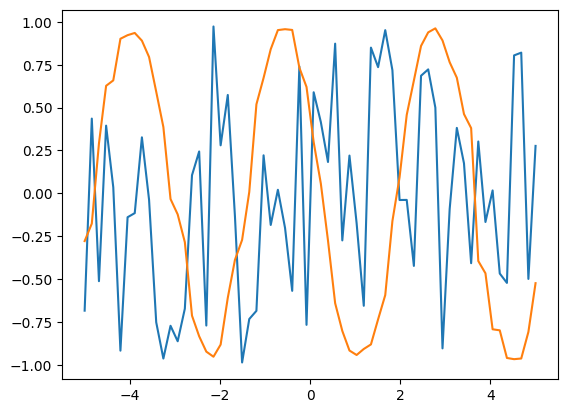

1/1 [==============================] - 0s 23ms/step


array([[0.10587182]], dtype=float32)

In [16]:
#avvia questa sezione per vedere differenti risultati e l'input che li ha generati
x = uniform(Y_MIN, Y_MAX, size = (1, TRAIN_LEN))
y = generator.predict(x)[0]
plt.plot(X_COORDS, x[0])
plt.plot(X_COORDS, y)
plt.show()

discriminator.predict(y.reshape(1, TRAIN_LEN))